In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point


import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('nyc_taxi_trip_duration.csv')

In [3]:
data.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id1080784          2  2016-02-29 16:40:21  2016-02-29 16:47:01   
1  id0889885          1  2016-03-11 23:35:37  2016-03-11 23:53:57   
2  id0857912          2  2016-02-21 17:59:33  2016-02-21 18:26:48   
3  id3744273          2  2016-01-05 09:44:31  2016-01-05 10:03:32   
4  id0232939          1  2016-02-17 06:42:23  2016-02-17 06:56:31   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.953918        40.778873         -73.963875   
1                2        -73.988312        40.731743         -73.994751   
2                2        -73.997314        40.721458         -73.948029   
3                6        -73.961670        40.759720         -73.956779   
4                1        -74.017120        40.708469         -73.988182   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.771164                  N            400  
1         40.694931                  N           1100  
2         40.774918                  N           1635  
3         40.780628                  N           1141  
4         40.740631                  N            848

Dropping id column as it is generally useless

In [4]:
data = data.drop('id', axis=1)

Using .info() function, we can roughly see if there's any missing value and the data type of each column

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   vendor_id           729322 non-null  int64  
 1   pickup_datetime     729322 non-null  object 
 2   dropoff_datetime    729322 non-null  object 
 3   passenger_count     729322 non-null  int64  
 4   pickup_longitude    729322 non-null  float64
 5   pickup_latitude     729322 non-null  float64
 6   dropoff_longitude   729322 non-null  float64
 7   dropoff_latitude    729322 non-null  float64
 8   store_and_fwd_flag  729322 non-null  object 
 9   trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 55.6+ MB


We can confirm the null values with .isna().any() function

In [6]:
data.isna().any()

vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

We can change the datetime columns' data type to datetime type by using .to_datetime function from pandas

In [7]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [8]:
trip_per_month = data.groupby(data['pickup_datetime'].dt.to_period('M')).count()

In [9]:
trip_per_month

vendor_id  pickup_datetime  dropoff_datetime  \
pickup_datetime                                                 
2016-01             114401           114401            114401   
2016-02             119364           119364            119364   
2016-03             128316           128316            128316   
2016-04             125634           125634            125634   
2016-05             124201           124201            124201   
2016-06             117406           117406            117406   

                 passenger_count  pickup_longitude  pickup_latitude  \
pickup_datetime                                                       
2016-01                   114401            114401           114401   
2016-02                   119364            119364           119364   
2016-03                   128316            128316           128316   
2016-04                   125634            125634           125634   
2016-05                   124201            124201           124201   
2016-06                   117406            117406           117406   

                 dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
pickup_datetime                                                            
2016-01                     114401            114401              114401   
2016-02                     119364            119364              119364   
2016-03                     128316            128316              128316   
2016-04                     125634            125634              125634   
2016-05                     124201            124201              124201   
2016-06                     117406            117406              117406   

                 trip_duration  
pickup_datetime                 
2016-01                 114401  
2016-02                 119364  
2016-03                 128316  
2016-04                 125634  
2016-05                 124201  
2016-06                 117406

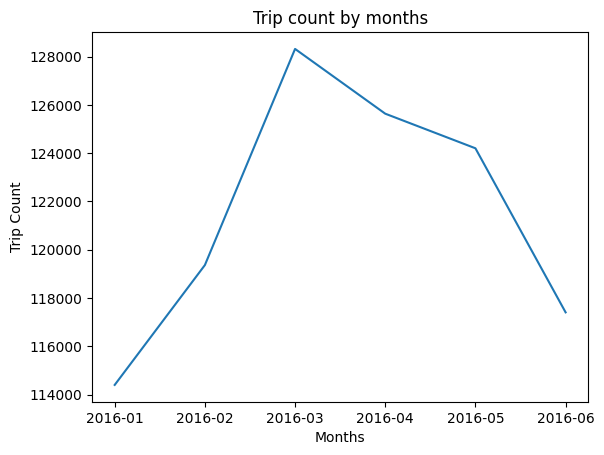

In [10]:
plt.plot(trip_per_month.index.astype(str), trip_per_month['vendor_id'])
plt.xlabel('Months')
plt.ylabel('Trip Count')
plt.title('Trip count by months')
plt.show()

Based on the chart above, we can see that the trend was going upwards and peaked in March 2016, then it started to decline.

In [11]:
trip_per_month_vendor = data.groupby([data['pickup_datetime'].dt.to_period('M'), 'vendor_id']).size().unstack()

In [12]:
trip_per_month_vendor

vendor_id            1      2
pickup_datetime              
2016-01          52660  61741
2016-02          55151  64213
2016-03          59394  68922
2016-04          58786  66848
2016-05          57928  66273
2016-06          54922  62484

Text(0.5, 1.0, 'Trip Count by Months per Vendor')

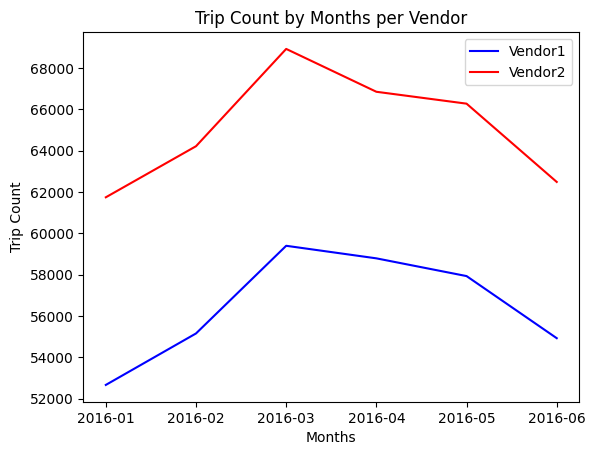

In [13]:
plt.plot(trip_per_month_vendor.index.astype(str), trip_per_month_vendor[1], label='Vendor1', color='blue')
plt.plot(trip_per_month_vendor.index.astype(str), trip_per_month_vendor[2], label='Vendor2', color='red')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Trip Count')
plt.title('Trip Count by Months per Vendor')

Looking at the line chart, It can be seen that Vendor 2 (vendor_id = 2) had more trips than vendor 1 (vendor_id = 1) by significant amount. The trend between these two vendors was generally the same, however Vendor 1 seemed to have a more steady decline rather than Vendor 2 who had a significant drop. 

Vendor 1 also closed the trend with a higher difference than Vendor 2.

In [14]:
passenger_per_month_vendor = data.groupby([data['pickup_datetime'].dt.to_period('M'), 'vendor_id'])['passenger_count'].sum().unstack()

In [15]:
passenger_per_month_vendor

vendor_id            1       2
pickup_datetime               
2016-01          65879  125136
2016-02          68556  129210
2016-03          74748  138108
2016-04          74075  135450
2016-05          73524  133217
2016-06          69634  124636

Text(0.5, 1.0, 'Passenger Count by Months per Vendor')

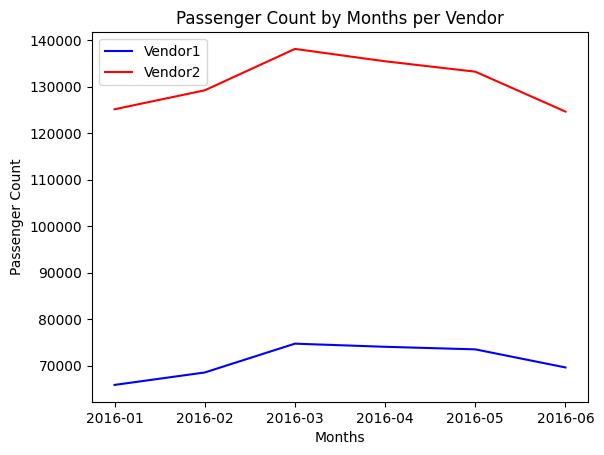

In [16]:
plt.plot(passenger_per_month_vendor.index.astype(str), passenger_per_month_vendor[1], label='Vendor1', color='blue')
plt.plot(passenger_per_month_vendor.index.astype(str), passenger_per_month_vendor[2], label='Vendor2', color='red')
plt.legend()
plt.xlabel('Months')
plt.ylabel('Passenger Count')
plt.title('Passenger Count by Months per Vendor')

It can be seen from the line chart that Vendor 2 picked up significantly more passenger than Vendor 1, with the similar trend style and differences as Trip count per months per vendor chart.

In [17]:
passenger_by_vendor = data.groupby(['vendor_id'])['passenger_count'].sum()

Text(0.5, 1.0, 'Passenger Count by Vendor')

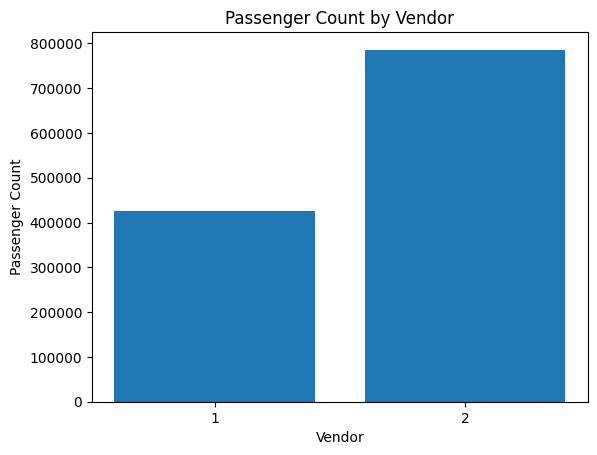

In [18]:
plt.bar(passenger_by_vendor.index.astype(str), passenger_by_vendor)
plt.xlabel('Vendor')
plt.ylabel('Passenger Count')
plt.title('Passenger Count by Vendor')

Using this bar chart, we can see that Vendor 2 picked up signficantly more passenger than Vendor 1.

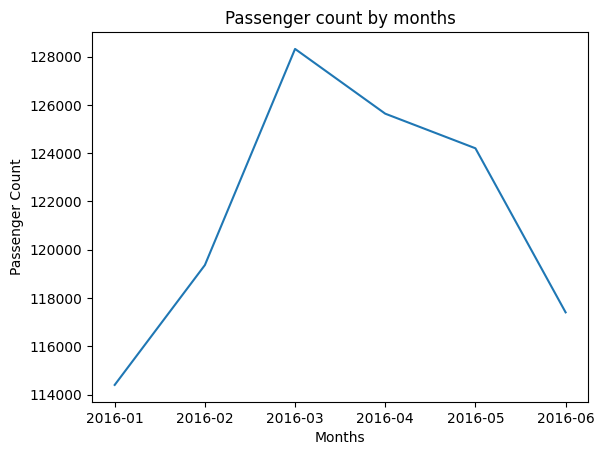

In [19]:
pass_per_month = data.groupby(data['pickup_datetime'].dt.to_period('M'))['passenger_count'].sum()

plt.plot(pass_per_month.index.astype(str), trip_per_month['vendor_id'])
plt.xlabel('Months')
plt.ylabel('Passenger Count')
plt.title('Passenger count by months')
plt.show()

Passenger count also follows the trend that trip count per months had, with a peak in March 2016, this can prove that  the number of passengers is directly related to the number of trips.

In [20]:
pass_per_month

pickup_datetime
2016-01    191015
2016-02    197766
2016-03    212856
2016-04    209525
2016-05    206741
2016-06    194270
Freq: M, Name: passenger_count, dtype: int64

In [21]:
duration_by_hour = data.copy()
duration_by_hour['hour'] = duration_by_hour['pickup_datetime'].dt.hour
average_duration_by_hour = duration_by_hour.groupby(['hour'])['trip_duration'].mean()

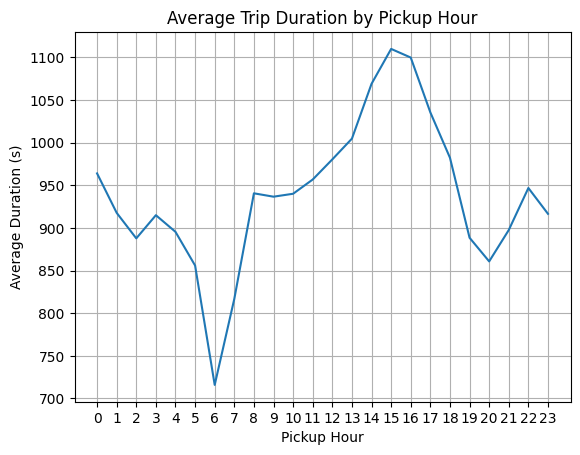

In [22]:
plt.plot(average_duration_by_hour.index.astype(str), average_duration_by_hour)
plt.xlabel('Pickup Hour')
plt.ylabel('Average Duration (s)')
plt.title('Average Trip Duration by Pickup Hour')
plt.grid()
plt.show()

Based on the chart, it can be seen that the longest trip tend to happen in the afternoon around 2-5 pm, with the busiest time being around 3-4 pm. This is likely due to traffic or high demand as people are heading home from work or school. The shortest trip tend to happen in the morning around 6 am.

In [23]:
day_df = data.copy()
day_df['day'] = day_df['pickup_datetime'].dt.day_name()
average_duration_by_day = day_df.groupby(['day'])['trip_duration'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
average_duration_by_day = average_duration_by_day.reset_index()
average_duration_by_day['day'] = pd.Categorical(average_duration_by_day['day'], categories=day_order, ordered=True)
average_duration_by_day = average_duration_by_day.sort_values(by='day')

In [24]:
average_duration_by_day

day  trip_duration
1     Monday     893.184555
5    Tuesday     980.550279
6  Wednesday     975.899557
4   Thursday    1005.446929
0     Friday     990.022999
2   Saturday     913.986114
3     Sunday     894.571088

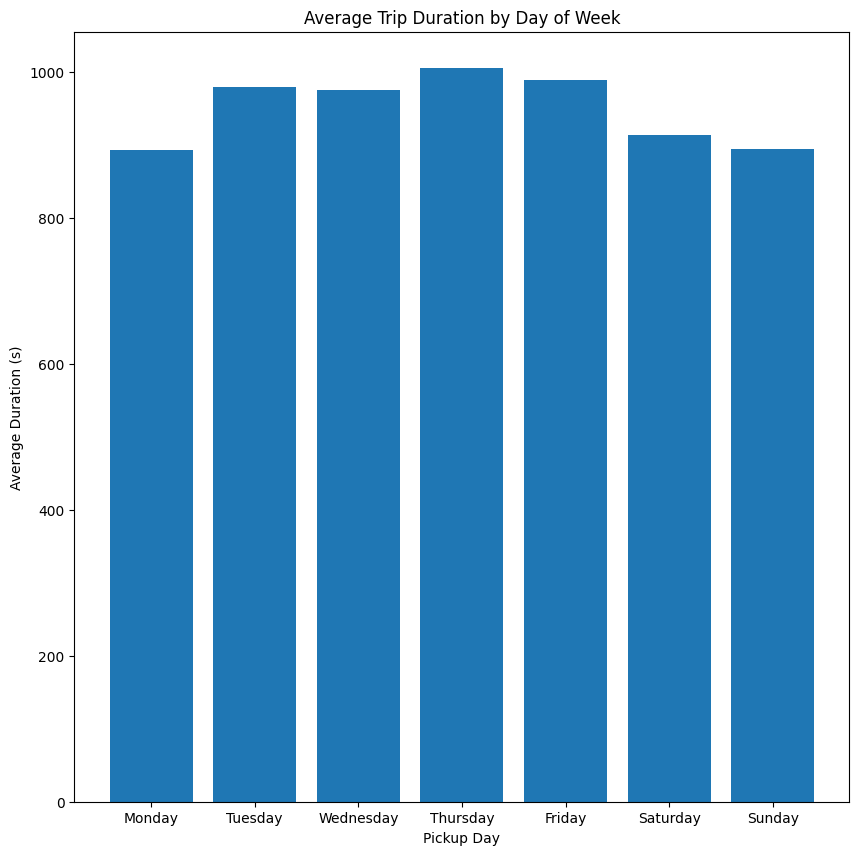

In [25]:
plt.figure(figsize=(10,10))
plt.bar(average_duration_by_day['day'], average_duration_by_day['trip_duration'])
plt.xlabel('Pickup Day')
plt.ylabel('Average Duration (s)')
plt.title('Average Trip Duration by Day of Week')
plt.show()

From the bar chart, thursday had the highest duration, followed by friday and tuesday. This can be due to several factors, such as high demand or something else. To look at the demand in each day, we will look at the chart below.

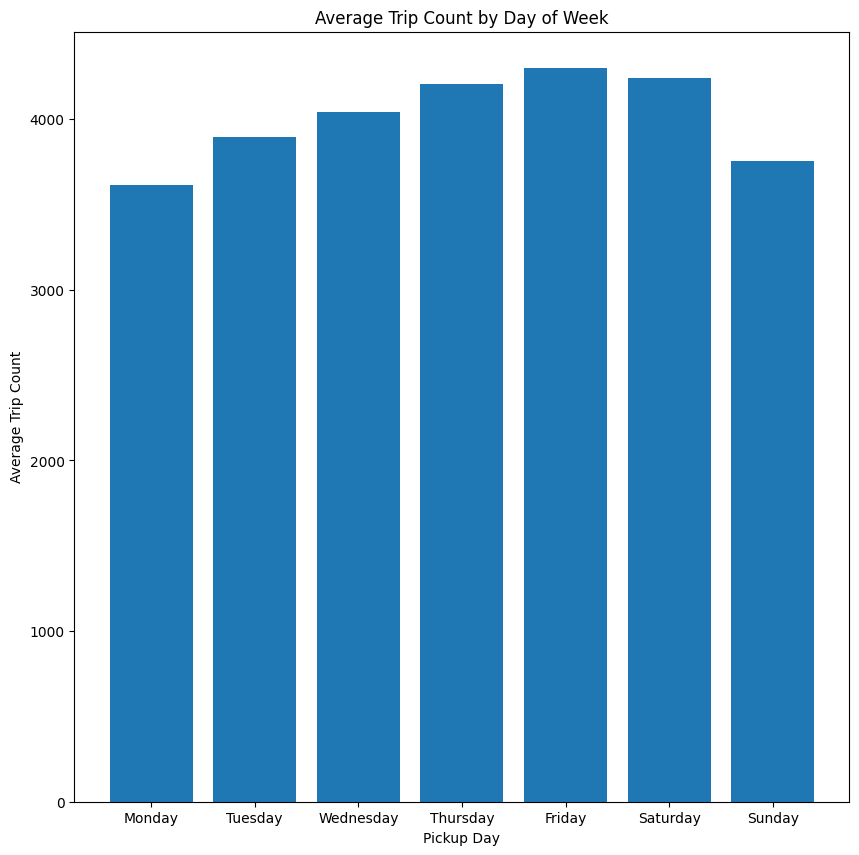

In [26]:
day_df['date'] = day_df['pickup_datetime'].dt.date
trip_by_day = day_df.groupby(['day', 'date']).size().reset_index(name='trip_count')
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
trip_by_day = trip_by_day.groupby(['day'])['trip_count'].mean().reset_index(name='Average trips')
trip_by_day['day'] = pd.Categorical(trip_by_day['day'], categories=day_order, ordered=True)
trip_by_day = trip_by_day.sort_values(by='day')

plt.figure(figsize=(10,10))
plt.bar(trip_by_day['day'], trip_by_day['Average trips'])
plt.xlabel('Pickup Day')
plt.ylabel('Average Trip Count')
plt.title('Average Trip Count by Day of Week')
plt.show()

This proves our initial assumption wrong as friday has the highest average demand but thursday has the longest average duration. This means that the cause for long duration might be other reasons such as long distance trips, etc.

In [27]:
trip_pass = pd.concat([trip_per_month['vendor_id'], pass_per_month], axis=1)
trip_pass = trip_pass.rename(columns={'vendor_id':'trip_count'})
trip_pass

trip_count  passenger_count
pickup_datetime                             
2016-01              114401           191015
2016-02              119364           197766
2016-03              128316           212856
2016-04              125634           209525
2016-05              124201           206741
2016-06              117406           194270

<Axes: >

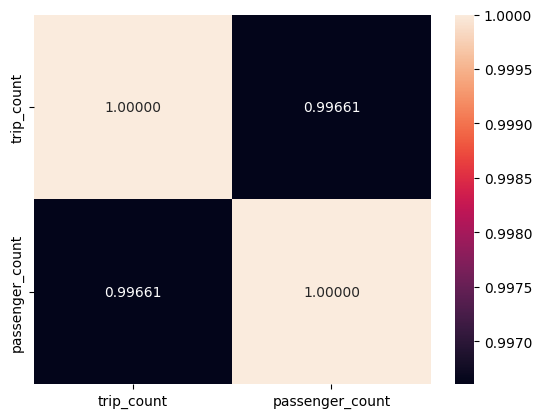

In [28]:
trip_pass_corr = trip_pass.corr()
sns.heatmap(trip_pass_corr, annot=True,fmt='.5f')

This Correlation Matrix shows that trip count and passenger count are highly correlated. Which means that the more trips a vendor gets, the higher the passenger count is, which makes a lot of sense.

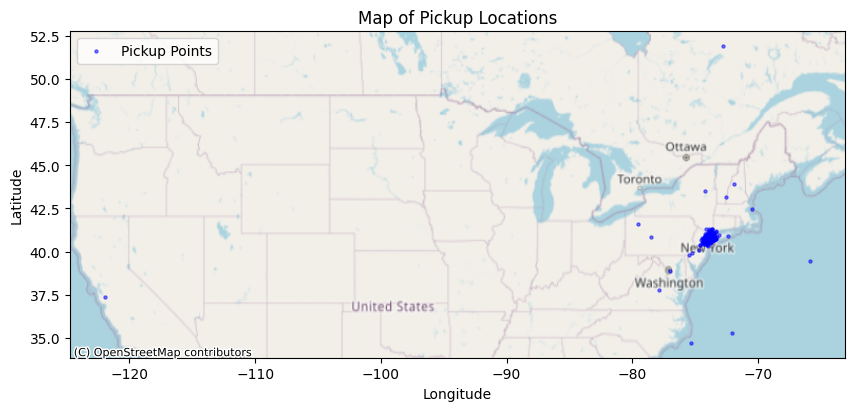

In [29]:
geometry = [Point(xy) for xy in zip(data['pickup_longitude'], data['pickup_latitude'])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.5, label='Pickup Points')

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Map of Pickup Locations')
plt.legend()
plt.show()


From this map visualisation, we can see that the most common pickup locations are in New York. Some of them are most likely outliers as the pickup points are in the sea, which are not possible. One of them are also too far away and is a possible outliers. Others that are not in the concentrated area are either special cases or are also outliers.

In [30]:
# Removing Outliers
data = data[(data['pickup_longitude'] >= -90) & (data['pickup_longitude'] <= -75) |
            (data['pickup_latitude'] >= 36) & (data['pickup_latitude'] <= 45)]

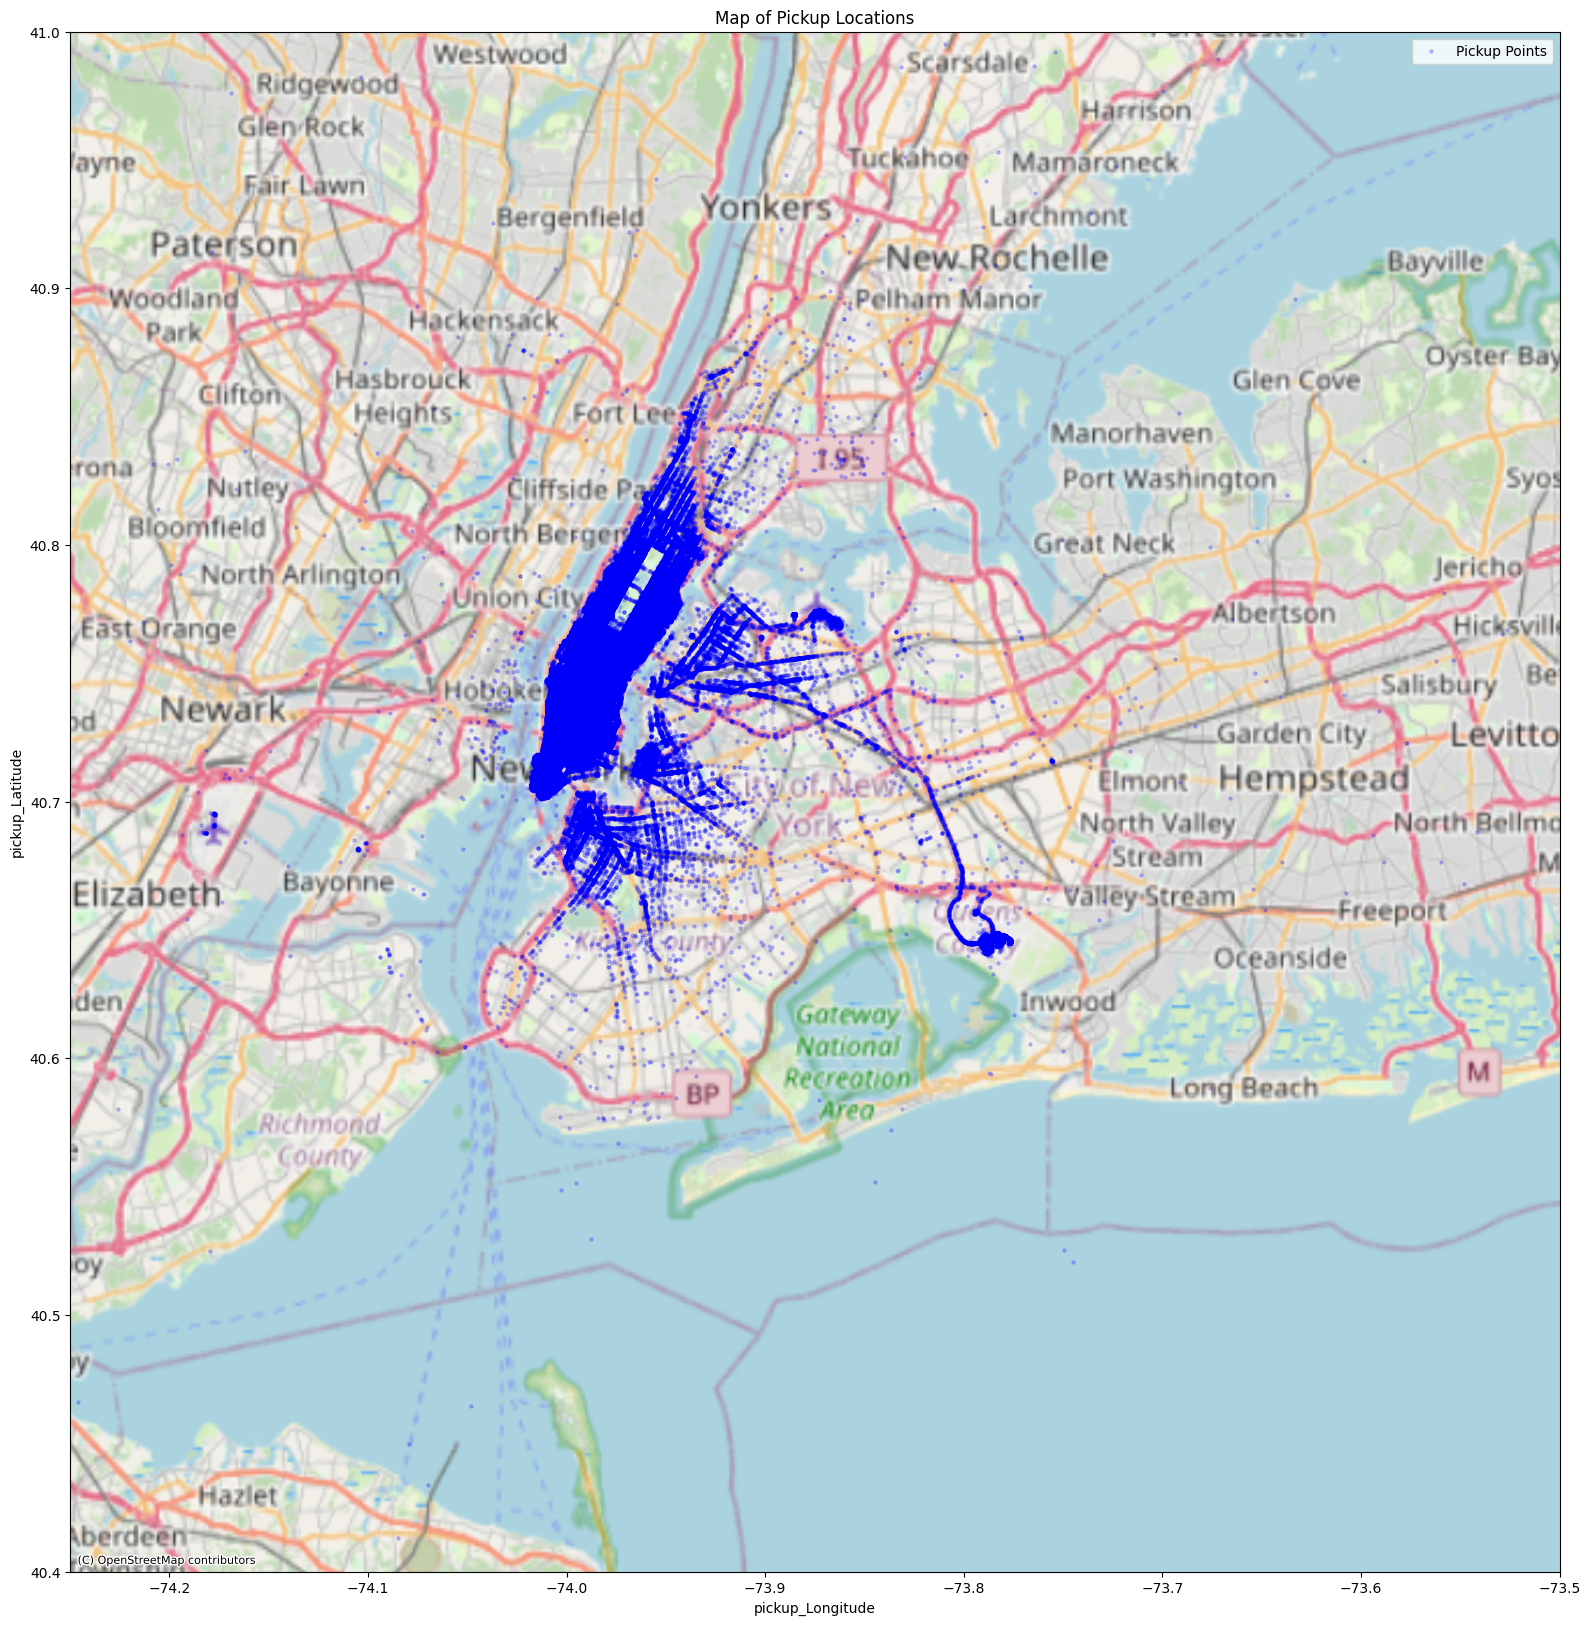

In [31]:
#Focus on denser area

geometry = [Point(xy) for xy in zip(data['pickup_longitude'], data['pickup_latitude'])]
geo_df = gpd.GeoDataFrame(data, geometry=geometry, crs="EPSG:4326")


fig, ax = plt.subplots(figsize=(20, 20))
geo_df.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.2, label='Pickup Points')

ax.set_xlim([-74.25, -73.5]) 
ax.set_ylim([40.4, 41])

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


plt.xlabel('pickup_Longitude')
plt.ylabel('pickup_Latitude')
plt.title('Map of Pickup Locations')
plt.legend()
plt.show()


As can be seen from the map, those are the streets or area with the most pickup in New York. This shows that more taxis need to be available in those areas to meet the demand and increase profits.

In [32]:
data['trip_duration'].describe().apply(lambda x: f"{x:,.0f}")

count      729,320
mean           952
std          3,865
min              1
25%            397
50%            663
75%          1,075
max      1,939,736
Name: trip_duration, dtype: object

Based on these informations, we can see that there is an outlier. <br>
Let's try visualising this outlier.

In [33]:
data[data['trip_duration'] == 1939736]
max_dur = data[data['trip_duration'] == 1939736]

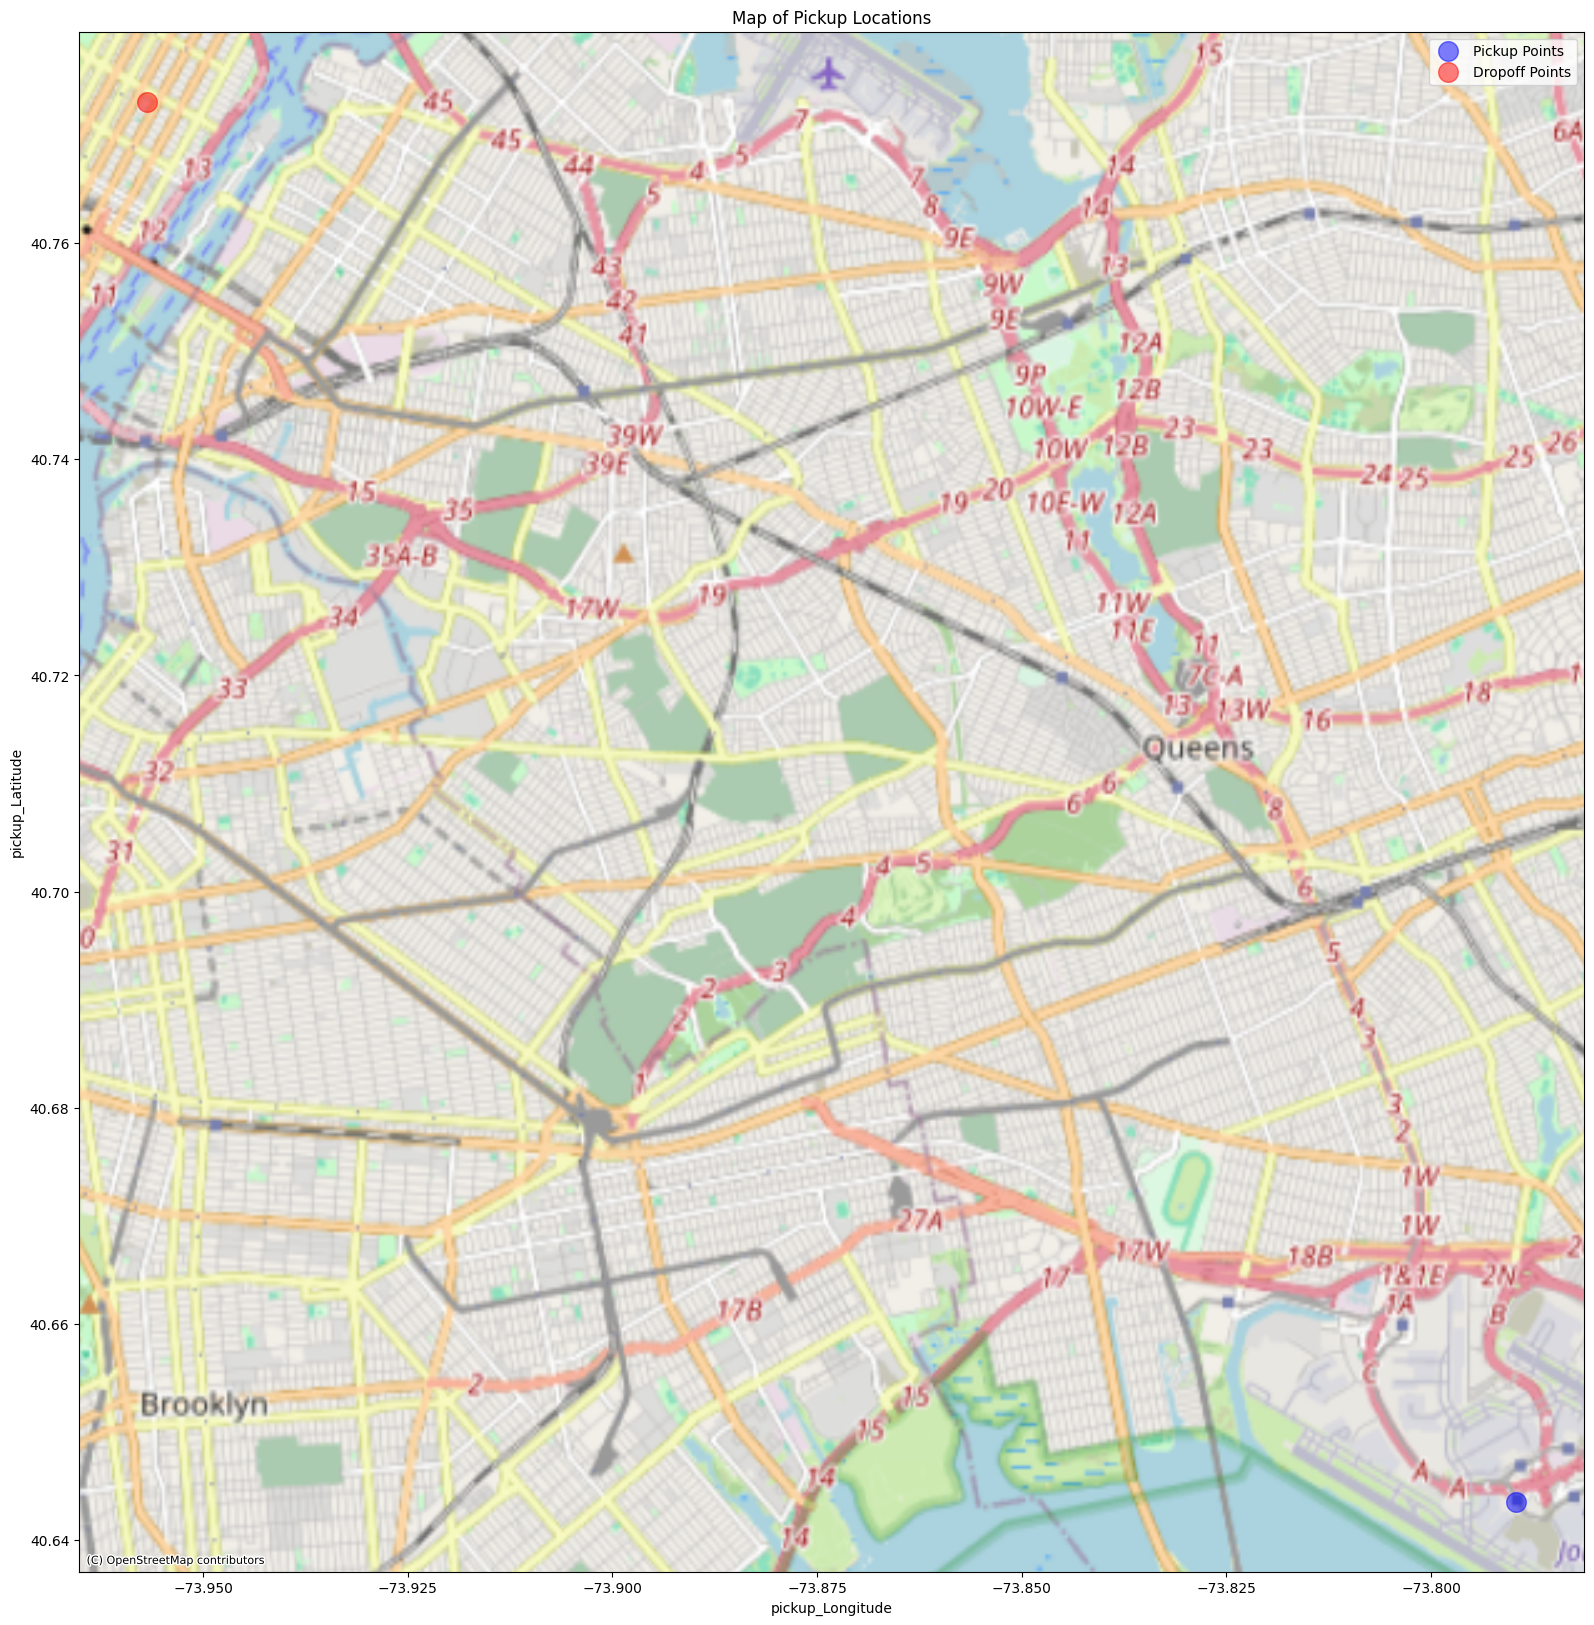

In [35]:
#Focus on denser area

geometry = [Point(xy) for xy in zip(max_dur['pickup_longitude'], max_dur['pickup_latitude'])]
geo_df = gpd.GeoDataFrame(max_dur, geometry=geometry, crs="EPSG:4326")

g2 = [Point(xy) for xy in zip(max_dur['dropoff_longitude'], max_dur['dropoff_latitude'])] 
g2_df = gpd.GeoDataFrame(max_dur, geometry=g2, crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(20, 20))
geo_df.plot(ax=ax, marker='o', color='blue', markersize=200, alpha=0.5, label='Pickup Points')
g2_df.plot(ax=ax, marker='o', color='red', markersize=200, alpha=0.5, label='Dropoff Points')

ctx.add_basemap(ax, crs=geo_df.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)


plt.xlabel('pickup_Longitude')
plt.ylabel('pickup_Latitude')
plt.title('Map of Pickup Locations')
plt.legend()
plt.show()


Although the point is faraway, there it is impossible for a trip to take 1.9 million seconds even with traffic 

Assuming the trip duration is in seconds, to remove the outlier, the upper limit will be set to 3 hours

In [36]:
initial_count = data.shape[0]
Q1 = data['trip_duration'].quantile(0.25)
Q3 = data['trip_duration'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = 3600*3

data = data[(data['trip_duration'] >= lower_bound) & (data['trip_duration'] <= upper_bound)]
new_count = data.shape[0]
print(f"Old data size: {initial_count} records")
print(f"New data size: {new_count} records")
print(f"Outliers removed: {initial_count-new_count}")

Old data size: 729320 records
New data size: 728289 records
Outliers removed: 1031


# Data Preprocessing 

We won't be needing pickup datetime and dropoff datetime as we're predicting duration, but it might be beneficial to use the hours

In [37]:
data['pickup_hour'] = data['pickup_datetime'].dt.hour

In [38]:
data = data.drop(['pickup_datetime','dropoff_datetime'], axis=1)

Encoding the categorical variable

In [39]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data['store_and_fwd_flag'] = encoder.fit_transform(data['store_and_fwd_flag'])

We are keeping vendor id as it is a binary vendor and this might be an indicatore for the duration too.

In [40]:
#Defining features and Target
X = data.drop('trip_duration', axis=1)
y = data['trip_duration']

#Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [41]:
X_train.head()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
429816          1                2        -73.781914        40.644840   
310384          1                1        -73.970451        40.751858   
485890          1                1        -73.937515        40.804150   
37936           1                1        -73.980721        40.742027   
174975          1                1        -74.006584        40.744171   

        dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_hour  
429816         -73.985336         40.753357                   0           13  
310384         -73.966980         40.759472                   0           21  
485890         -73.946159         40.781101                   0            6  
37936          -73.938316         40.792084                   0           22  
174975         -73.989052         40.748234                   0            0

In [44]:
#Features scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scale_features = ['passenger_count', 'pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude','pickup_hour']
X_train[scale_features] = scaler.fit_transform(X_train[scale_features])
X_test[scale_features] = scaler.transform(X_test[scale_features])

In [46]:
from sklearn.linear_model import LinearRegression

linear_regressor =  LinearRegression()
linear_model = linear_regressor.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

In [47]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, linear_pred)

444.91648854094564

The MAE score explains the error in prediction. In Linear Regression model, the error is around 7.3 minutes, which is a little bit high, but still acceptable.

In [48]:
from sklearn.ensemble import RandomForestRegressor

rfg = RandomForestRegressor()
rfg.fit(X_train, y_train)
rfg_pred = rfg.predict(X_test)

In [49]:
mean_absolute_error(y_test, rfg_pred)

205.37932502751067

For a average period of 900+ seconds or about 15 minutes, around 3 minutes error seems appropriate.

In conclusion, in a business perspective, Vendor 2 seems to be a company with higher sales which normally equates to higher revenue. To gain even more advantage, Vendor 2 can focus its fleet on the high-demand areas as visualised on the map.

On the other hand, to gain a more competitive advantage, Vendor 1 can also focus its fleet on the high-demand areas.